# Objectives:

This project implements a Monte Carlo exposure simulation for a forward-starting interest rate swap under the Hull–White one-factor short-rate model, using QuantLib and Python.

The workflow consists of:
- Constructing a flat yield curve and calibrating a Hull–White short-rate process
- Simulating short-rate paths via Gaussian Monte Carlo
- Valuing a payer interest rate swap dynamically along each simulated path
- Computing dirty mark-to-market values between coupon dates (including accrued interest)
- Aggregating pathwise results into standard counterparty credit risk exposure metrics:
    - Expected Future Value (EFV)
    - Expected Exposure (EE)
    - Negative Expected Exposure (NEE)

- Comparing stochastic exposure profiles against the deterministic forward-start swap valuation implied by today’s curve
The project demonstrates a model-consistent exposure framework suitable for applications such as:
- Counterparty Credit Risk (CCR)
- CVA / FVA analytics
- IFRS 13 fair valuation
- Regulatory risk modeling and validation

The implementation emphasizes:
- Analytical Hull–White zero-coupon bond pricing
- Accurate accrual handling (“dirty” valuation)
- Clear separation between simulation, valuation, and exposure aggregation 

# Monte Carlo simulation

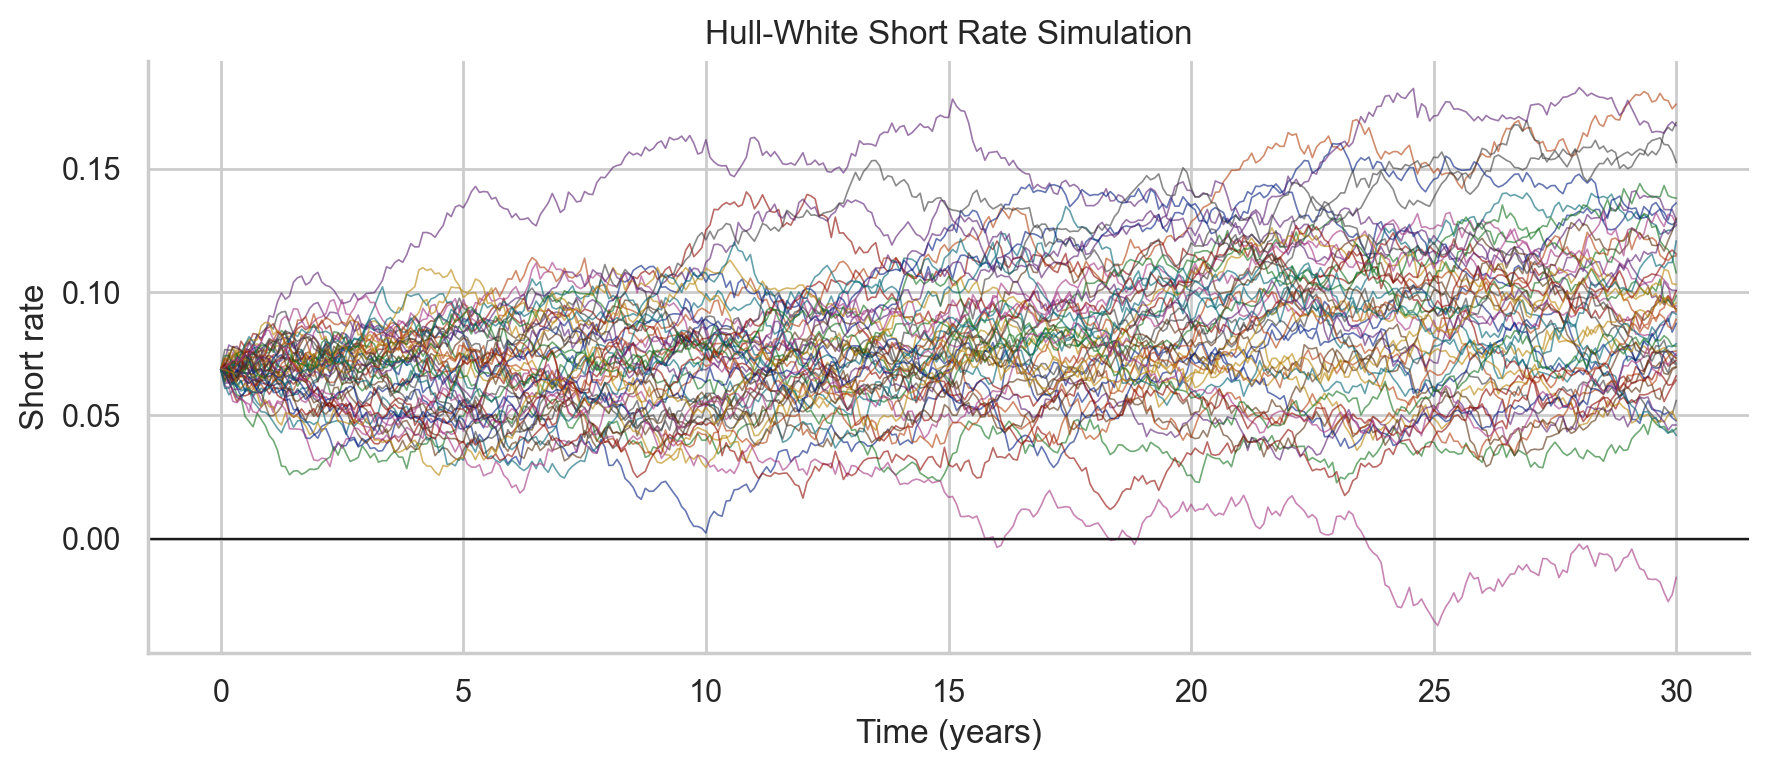

In [1]:
import QuantLib as ql
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.integrate import cumulative_trapezoid

%config InlineBackend.figure_format = 'retina'

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='dark', 
              color_codes=True, 
              rc={'figure.figsize': [9, 4]})


# ---------- Settings & conventions ----------
eval_date = ql.Date(24, ql.October, 2025)
ql.Settings.instance().evaluationDate = eval_date

zar_cal     = ql.SouthAfrica()
bdc         = ql.ModifiedFollowing
dc_act365   = ql.Actual365Fixed()

timestep = 360
length = 30 # in years
forward_rate = 0.06868

ql.Settings.instance().evaluationDate = eval_date
yield_curve = ql.FlatForward(eval_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), dc_act365)
spot_curve_handle = ql.YieldTermStructureHandle(yield_curve)

a_hat, sigma_hat = 0.03, 0.01

# set up the MonteCarlo simulation of the Hull-White process:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a_hat, sigma_hat)
rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(
        timestep,
        ql.UniformRandomGenerator(125)
    )
)
seq = ql.GaussianPathGenerator(
    hw_process,
    length,
    timestep,
    rng,
    False,
)

def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

num_paths = 50
time, paths = generate_paths(num_paths, timestep)

for i in range(num_paths):
    plt.plot(time, paths[i,:], lw=0.6, alpha=0.6)
plt.axhline(0.0, color="k", lw=0.85)
plt.title("Hull-White Short Rate Simulation")
plt.xlabel("Time (years)")
plt.ylabel("Short rate")
sns.despine()
plt.tight_layout()

# Simulation of a 10-year interest rate swap exposure

Initial NPV: 0.016883


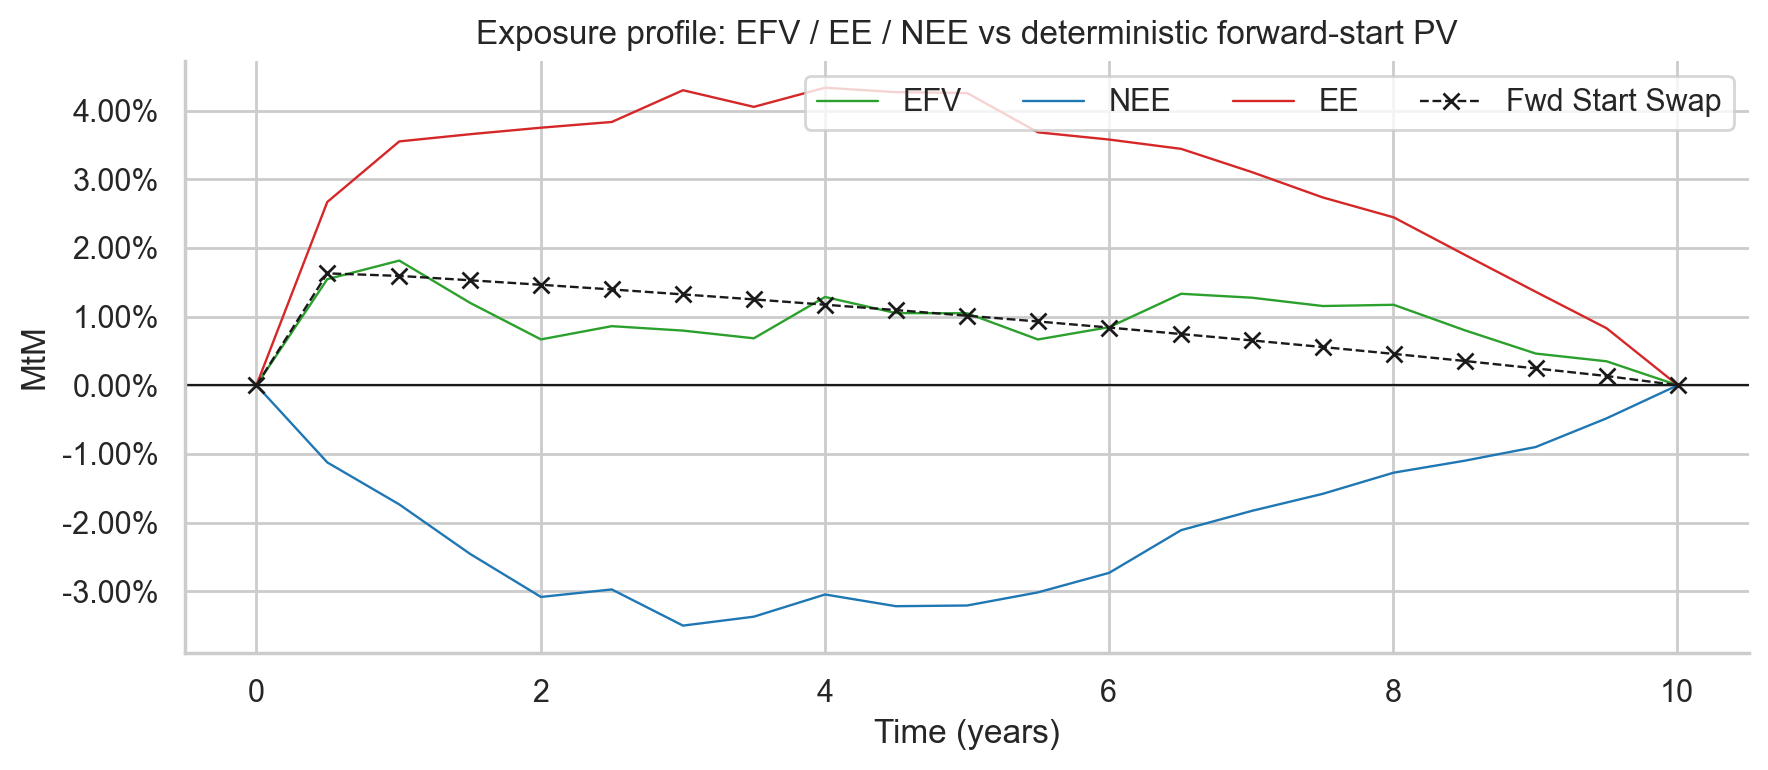

In [2]:
# ----- CONFIG ------
notional        = 1.0
years           = 10       
fixed_rate_K    = 0.0675   
pay_freq        = 2        
fwd_start_years = 0       

a_use, sigma_use = float(a_hat), float(sigma_hat)

# ----- UTILITIES -----
ql.Settings.instance().evaluationDate = eval_date

# ---------- schedule and helpers ----------
def swap_schedule(eval_date, years, cal, dc, pay_freq, fwd_start_years=0):
    start = cal.advance(eval_date, ql.Period(fwd_start_years, ql.Years))
    # payment dates
    pay_dates = [cal.advance(start, ql.Period(i * (12 // pay_freq), ql.Months))
                 for i in range(1, years * pay_freq + 1)]
    # previous period starts
    prev_dates = [start] + pay_dates[:-1]

    # accruals for full periods
    accruals = [dc.yearFraction(prev_dates[i], pay_dates[i]) for i in range(len(pay_dates))]

    # times (year fractions from eval_date)
    yf = ql.Actual365Fixed()
    pay_times  = [yf.yearFraction(eval_date, d) for d in pay_dates]
    prev_times = [yf.yearFraction(eval_date, d) for d in prev_dates]
    return pay_dates, prev_dates, pay_times, prev_times, accruals

pay_dates, prev_dates, pay_times, prev_times, accruals = swap_schedule(
    eval_date, years, zar_cal, dc_act365, pay_freq, fwd_start_years
)

# OPTIONAL: sanity check initial NPV
initial_swap = ql.MakeVanillaSwap(
    ql.Period(years, ql.Years),
    ql.Jibar(ql.Period(3, ql.Months), spot_curve_handle),
    fixed_rate_K,
    ql.Period(fwd_start_years, ql.Years),
    fixedLegTenor=ql.Period(12 // pay_freq, ql.Months),
    fixedLegDayCount=dc_act365,
    fixedLegConvention=bdc,
    fixedLegCalendar=zar_cal,
)
initial_swap.setPricingEngine(ql.DiscountingSwapEngine(spot_curve_handle))
print(f"Initial NPV: {initial_swap.NPV():.6f}")  # Should be >0 if K < forward

def hw_P(model: ql.HullWhite, t: float, T: float, r_t: float) -> float:
    return model.discountBond(t, T, r_t)

def fwd_from_bonds(P_t_T0: float, P_t_T1: float, alpha: float) -> float:
    # simple-compounded forward L = (P(t,T0)/P(t,T1) - 1)/alpha
    return (P_t_T0 / P_t_T1 - 1.0) / alpha

# ---------- dirty MTM under HW (smooth between coupons) ----------
def hw_swap_pv_payer_dirty(model: ql.HullWhite, t: float, r_t: float,
                           pay_times: list, prev_times: list, accruals: list,
                           K: float, daycounter: ql.DayCounter, N: float=1.0) -> float:
    # find current period i with t in [prev_i, pay_i); if after last payment -> 0
    n = len(pay_times)
    i = next((k for k in range(n) if t <= pay_times[k]), None)
    if i is None:
        return 0.0

    # clean fixed PV of remaining coupons
    pv_fixed_clean = 0.0
    for k in range(i, n):
        pv_fixed_clean += K * accruals[k] * hw_P(model, t, pay_times[k], r_t)

    # clean floating PV using the general identity
    pv_float_clean = hw_P(model, t, prev_times[i], r_t) - hw_P(model, t, pay_times[-1], r_t)

        # accrued pieces (dirty = clean + accrued), all in model time
    alpha_i  = accruals[i]                 # full accrual of the current period
    alpha_pt = min(max(t - prev_times[i], 0.0), alpha_i)   # partial accrual from prev_i to t (years)

    accr_fixed = K * alpha_pt

    # floating accrued = L_{i-1}(t) * partial accrual
    P_t_Tprev = hw_P(model, t, prev_times[i], r_t)
    P_t_Ti    = hw_P(model, t, pay_times[i],  r_t)
    L_prev    = fwd_from_bonds(P_t_Tprev, P_t_Ti, alpha_i)
    accr_float = L_prev * alpha_pt


    pv_dirty = N * ((pv_float_clean + accr_float) - (pv_fixed_clean + accr_fixed))
    return pv_dirty

# deterministic forward-start PV line (dirty) from today's curve only
def P0(t):
    # discount at time t (years) from today's curve without converting to dates
    return spot_curve_handle.discount(t)

def P0ratio(t, T):
    return P0(T) / P0(t)


def det_swap_pv_payer_dirty_at_t(t, pay_times, prev_times, accruals, K, dc, N=1.0):
    n = len(pay_times)
    i = next((k for k in range(n) if t <= pay_times[k]), None)
    if i is None:
        return 0.0
    pv_fixed_clean = sum(K * accruals[k] * P0ratio(t, pay_times[k]) for k in range(i, n))
    pv_float_clean = P0ratio(t, prev_times[i]) - P0ratio(t, pay_times[-1])

    alpha_i  = accruals[i]
    alpha_pt = min(max(t - prev_times[i], 0.0), alpha_i)
    L_prev   = fwd_from_bonds(P0ratio(t, prev_times[i]), P0ratio(t, pay_times[i]), alpha_i)
    accr_fixed = K * alpha_pt
    accr_float = L_prev * alpha_pt

    return N * ((pv_float_clean + accr_float) - (pv_fixed_clean + accr_fixed))


# ----- BUILD HM MODEL AND MAP PATH GRID TO OBS TIMES -----
spot_curve_handle = ql.YieldTermStructureHandle(ql.FlatForward(eval_date, forward_rate, dc_act365))
# model with your params
hw_model = ql.HullWhite(spot_curve_handle, a_use, sigma_use)

# choose observation times
obs_times = pay_times

# map to indices in your simulation grid "time"
obs_idx = [int(np.searchsorted(time, t_obs, side='left')) for t_obs in obs_times]


# EFV / EE / NEE and deterministic line (dirty)
obs_times = [0.0] + pay_times
obs_idx   = [0] + [int(np.searchsorted(time, t_obs, side="left")) for t_obs in pay_times]

EFV, EE, NEE, det_line = [], [], [], []
for idx in obs_idx:
    t_obs = float(time[idx])
    r_slice = paths[:, idx]
    v = np.array([hw_swap_pv_payer_dirty(hw_model, t_obs, float(r),
                                         pay_times, prev_times, accruals,
                                         fixed_rate_K, dc_act365, notional)
                  for r in r_slice])
    EFV.append(v.mean())
    EE.append(np.maximum(v, 0.0).mean())
    NEE.append(np.minimum(v, 0.0).mean())
    det_line.append(
        det_swap_pv_payer_dirty_at_t(
            t_obs, pay_times, prev_times, accruals, fixed_rate_K, dc_act365, notional
        )
    )
    
EFV[0] = EE[0] = NEE[0] = 0.0
det_line[0] = 0.0

EFV  = np.array(EFV)
EE   = np.array(EE)
NEE  = np.array(NEE)
det_line = np.array(det_line)
t_obs_arr = np.array(obs_times)



# ====== GRAPH 2: EFV / EE / NEE / deterministic line ======
ax = plt.figure().add_subplot(1, 1, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda r, pos: f"{r:.2%}"))
plt.plot(t_obs_arr, EFV, label="EFV", color='tab:green', lw=0.85)
plt.plot(t_obs_arr, NEE, label="NEE", color='tab:blue', lw=0.85)
plt.plot(t_obs_arr, EE,  label="EE", color='tab:red', lw=0.85)
plt.plot(t_obs_arr, det_line, 'kx--', label="Fwd Start Swap", lw=0.85)  
plt.axhline(0.0, color='k', lw=0.8)
plt.legend(ncol=4, loc="upper right")
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.title("Exposure profile: EFV / EE / NEE vs deterministic forward-start PV")
sns.despine()
plt.tight_layout()